In [1]:
# 1. Imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
import shap

e:\University Labs\INTERNSHIP\tasks\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load Data

df = pd.read_csv('diabetes.csv')
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


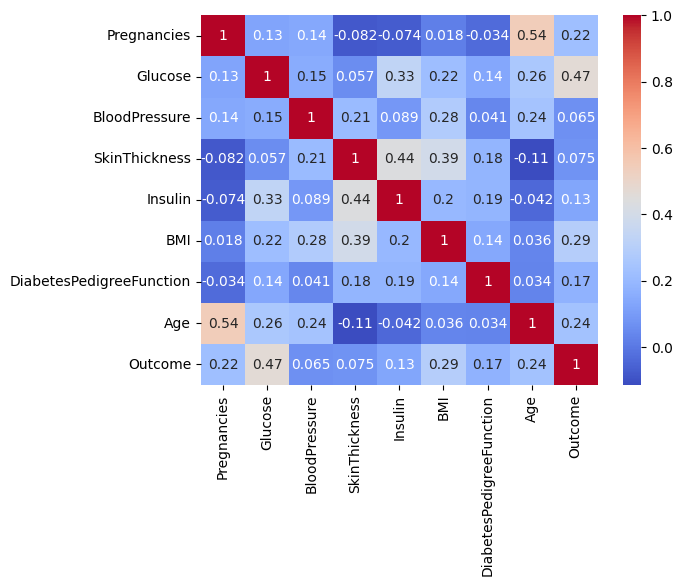

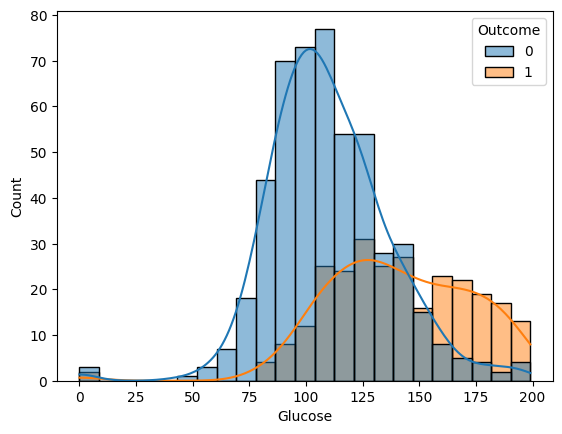

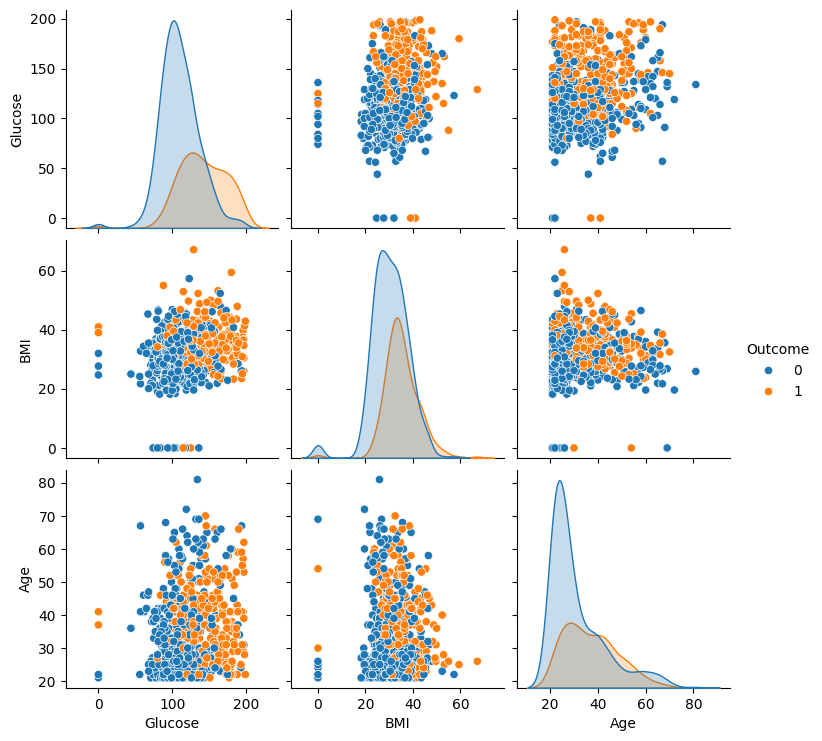

In [4]:
# EDA & Visualization

sns.heatmap(df.corr(), annot=True, cmap='coolwarm'); plt.show()
sns.histplot(data=df, x='Glucose', hue='Outcome', kde=True); plt.show()
sns.pairplot(df, hue='Outcome', vars=['Glucose', 'BMI', 'Age']); plt.show()

In [5]:
# Preprocessing

X = df.drop('Outcome', axis=1)
y = df['Outcome']
X.replace(0, np.nan, inplace=True)  # zeroes indicate missing for some features
X['Insulin'].fillna(X['Insulin'].median(), inplace=True)
X = X.fillna(X.median())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14460\2983564503.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['Insulin'].fillna(X['Insulin'].median(), inplace=True)


In [6]:
# Feature Selection

estimator = GradientBoostingClassifier(random_state=42)
selector = RFECV(estimator, step=1, cv=5, scoring='roc_auc')
X_sel = selector.fit_transform(X_scaled, y)
print("Selected features:", X.columns[selector.support_])

Selected features: Index(['Glucose', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'], dtype='object')


In [7]:
# Train/Test Split

X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size=0.2, stratify=y, random_state=42)

# Model Training & Evaluation
models = {
    'GB': GradientBoostingClassifier(random_state=1),
    'SVM': SVC(probability=True, random_state=1),
    'MLP': MLPClassifier(hidden_layer_sizes=(64,32), max_iter=500, random_state=1)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]
    results[name] = {
        'F1': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_prob),
        'model': model,
        'y_prob': y_prob
    }
print(pd.DataFrame(results).T[['F1','AUC']])

           F1       AUC
GB   0.613861  0.822963
SVM    0.5625   0.80537
MLP  0.666667  0.833889


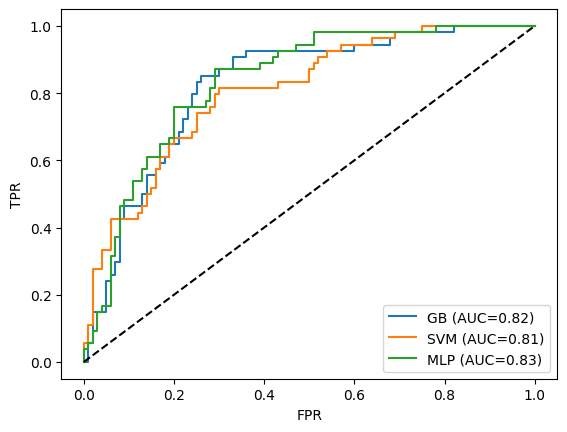

In [8]:
# Plot ROC

plt.figure()
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res['y_prob'])
    plt.plot(fpr, tpr, label=f"{name} (AUC={res['AUC']:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.legend(), plt.xlabel('FPR'), plt.ylabel('TPR')
plt.show()

Best model: MLP


100%|██████████| 10/10 [00:00<00:00, 49.84it/s]


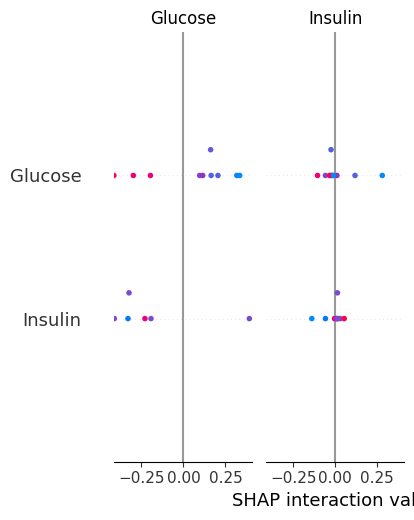

In [29]:
# SHAP Explainability - Final Fix
# SHAP Explainability - Final Fix
import shap
import numpy as np
import pandas as pd

# 1. Best model
best = max(results.keys(), key=lambda n: results[n]['AUC'])
print("Best model:", best)
model = results[best]['model']

# 2. Correct feature names
selected_feature_names = X.columns[selector.support_].tolist()

# 3. Background and test sample from selected features
X_background = pd.DataFrame(X_train[:100], columns=selected_feature_names)
X_test_sample = pd.DataFrame(X_test[:10], columns=selected_feature_names)

# 4. Define prediction function
def predict_proba_fn(x):
    return model.predict_proba(x)

# 5. SHAP explainer
explainer = shap.KernelExplainer(predict_proba_fn, X_background)

# 6. Compute SHAP values
shap_values = explainer.shap_values(X_test_sample)

# ✅ 7. Plot SHAP summary (directly use shap_values)
shap.summary_plot(
    shap_values,                # not shap_values[1]
    features=X_test_sample,
    feature_names=selected_feature_names,
    plot_size=(24, 6),            # ✅ Bigger plot
    show=True,                    # ✅ Show plot immediately
    plot_type="bar",              # Optional: or "dot"
    max_display=10                # Optional: top N features
)




